In [ ]:
# State vector: [t, ξ, p_2, a_4, S0, S0'], var_vec.
# var_vec: Phi, S, Sdot, PhiDot, A.
# 
# T = BigFloat;
# setprecision(T,128)

T = Float64;

# --------------------------------------------------------------
#  Struct definition: this holds all variables at a grid point.
# --------------------------------------------------------------/

struct PDEVars{T}
    Phi::T
    S::T
    Sdot::T
    Phidot::T
    A::T
    PhiZ::T
    SZ::T
    SdotZ::T
    PhidotZ::T
    AZ::T
    PhiZZ::T
    SZZ::T
    SdotZZ::T
    PhidotZZ::T
    AZZ::T
    z::T
    LN::T
    t::T
    X::T
    p2::T
    a4::T
    DS0::T
    DS1::T
    DS2::T
    DS3::T
    DS4::T
end

using Plots
using Parameters: @unpack

include("cheb.jl")
include("Equation expressions/ODECoeffExpr.jl");
include("Equation expressions/FlatS0Expr.jl");
include("Equation expressions/CosmoTimeStepExpr.jl");
include("Equation expressions/CosmoConstrExpr.jl");
include("solvers.jl")

global const M = T(1.);

global const z_boundaries = [zero(T), T(0.1),T(0.25), T(0.4),T(0.52)]; #Boundaries of grid domains.
global const domain_sizes = [15, 15, 15, 15]; #sizes of all domains.
global const Ndom = length(domain_sizes);
global const N = sum(domain_sizes);

global const zero_var = [zeros(T,n) for n in domain_sizes]; #Helpful for getting arrays of the right shape


diff2_mats, diff1_mats, grids, damp_mats = MultiGridChebyshev(z_boundaries,domain_sizes);

Vfun(x) = ( -576. - 288. * x^2 - 64. * x^4 + 22. * x^6 - x^8) / 192.;
DV(x) = - x * (144. + 64. * x^2 - 33. * x^4 + 2. * x^6) / 48.;

In [3]:
global domAH = 4;
global indAH = 12;

global zAH = grids[domAH][indAH];
display(zAH)


0.5069098889480818

In [4]:
init_a4 = -T(2000.);
initDS0 = one(T);
init_params = [-one(T), zero(T), zero(T), init_a4, initDS0, 0];
init_guess = [zero_var for var in 1:NVar];
Var = copy(init_guess);


VarZ,VarZZ = ComputeDerivatives(Var);

for ii in 1:500
    Var[ind_s] = LinearSolveODE(1, init_params, Var, VarZ, VarZZ);
    VarZ[ind_s] = ComputeSingleDerivative(Var[ind_s]);
    VarZZ[ind_s] = ComputeSingleDerivative(Var[ind_s], deg=2);

    Var[ind_sdot] = LinearSolveODE(2, init_params, Var, VarZ, VarZZ);
    VarZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot]);
    VarZZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot], deg=2);

    newX = CorrectXi(init_params, Var);
    print("\rX = $newX");
    flush(stdout);

    init_params[ind_X] = newX;
    init_params[ind_S1] = DS1f(init_params);
end

InitVar = ComputeBulk(init_params, Var);

X = 4.6579791947614185

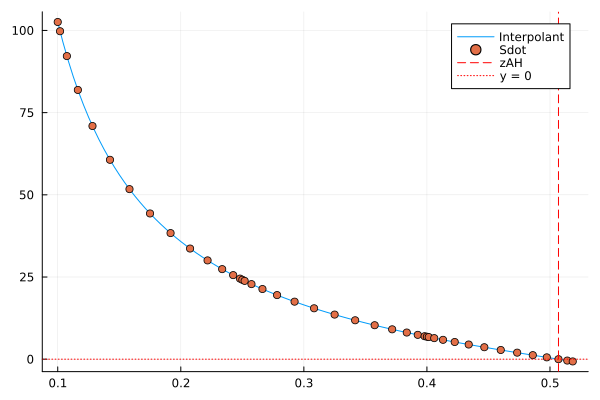

In [5]:
fig = PlotSdot(init_params,InitVar);
display(fig)

In [6]:
dt = T(.0002);


outfile = [];
monitorfile = [];

FinalParams, VarFinal = Evolve(init_params,InitVar, 0, dt, 500, outfile, monitorfile);

# close(outfile);
# close(monitorfile);

◑ time = -0.008, constraint violation = 0.363,  Sdot at zAH = 0.000    Time: 0:00:11m9m

In [7]:
length(outfile)

11

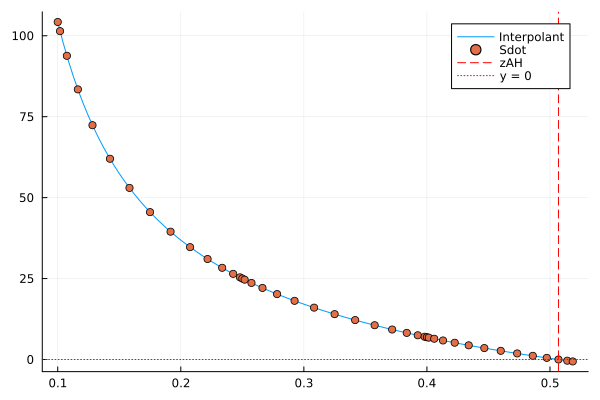

In [8]:
ind =11;
fig = PlotSdot(monitorfile[ind][2],outfile[ind]);
# title!(fig, string("time = ",format(monitorfile[ind][1],precision=2)))
display(fig)

In [9]:
using Serialization

open("Data files/FlatInitialData.dat","w") do io
    serialize(io, [FinalParams, VarFinal]);
end